In [5]:
from main import main
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pickle
%matplotlib inline

In [8]:
#Set the style for latex-like plots
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [2]:
# Read results from pickles.
seeds = ['0.1', '0.2', '0.5']
metrics_names = ['precision', 'recall', 'f1_score']
metrics = {}
timings = {}

for m in metrics_names:
    metrics[m] = {}
for s in seeds:
    with open("data/pkl/{seed}/precisions.pkl".format(seed=s), "rb") as f:
        metrics['precision'][s] = pickle.load(f)
    with open("data/pkl/{seed}/recalls.pkl".format(seed=s), "rb") as f:
        metrics['recall'][s] = pickle.load(f)
    with open("data/pkl/{seed}/f1_scores.pkl".format(seed=s), "rb") as f:
        metrics['f1_score'][s] = pickle.load(f)
    with open("data/pkl/{seed}/timings.pkl".format(seed=s), "rb") as f:
        timings[s] = pickle.load(f)

## Mean metric by iteration
Compute the mean of the measurements obtained for every metric and every seed, divided by the iteration.
Plot for all metrics and seeds the trend of the means, with error-bars.

In [10]:
def compute_mean_and_std_by_metric(metric: list):
    """
    Compute the mean and the standard deviation for each metric,
    grouped by every iteration of the algorithm.
    
    Arguments:
        metric: the name of the metric, among 'precision', 'recall' and 'f1_score' 
    Returns:
        
    """
    metric_means = []
    metric_stds = []   
    last_iter = max(metric[0].keys()) + 1
    for i in range(last_iter):
        iter_values = [val[i] for val in metric]
        metric_means.append(np.mean(iter_values))
        metric_stds.append(np.std(iter_values))
    return metric_means, metric_stds

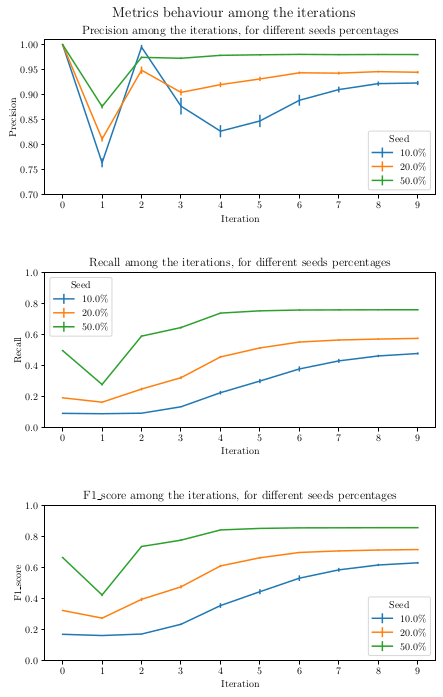

In [11]:
seeds = ['0.1', '0.2', '0.5']
metrics_names = ['precision', 'recall', 'f1_score']
title = "{} among the iterations, for different seeds percentages"
fig, axarr = plt.subplots(3, 1, figsize=(7,3))
plt.subplots_adjust(left=None, bottom=None, right=None, top=3, wspace=None, hspace=0.5)
for i, metric in enumerate(metrics_names):
    plt.subplot(3, 1, i+1, ymargin=1)
    for s in seeds:
        metric_means, metric_std = compute_mean_and_std_by_metric(metrics[metric][s])
        plt.title(title.format(metric.capitalize()))
        axes = plt.gca()
        if metric=="precision":
            axes.set_ylim([0.7,1.01])
        else:
            axes.set_ylim([0,1])
        plt.xticks(range(10))
        plt.xlabel("Iteration")
        plt.ylabel(metric.capitalize())
        plt.errorbar(range(len(metric_means)), metric_means, yerr=metric_std, label=str(float(s)*100)+"%")
    plt.legend(title="Seed")
fig.suptitle("Metrics behaviour among the iterations", y = 3.15, size=14);

## Time for seed
Plot the average time (with confidence intervals) for every experiment, divided by seed.

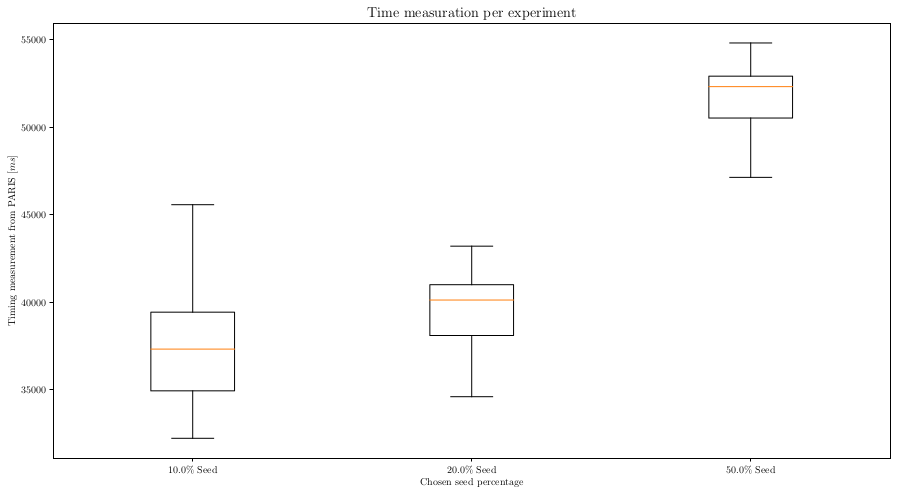

In [12]:
plt.figure(figsize=(15,8))
plt.title("Time measuration per experiment", size=14)
#plt.boxplot([timings['0.1'], timings['0.2'], timings['0.5']], labels=['time 0.1', 'time 0.2', 'time 0.5']);
# No idea why we cannot do it (We can ahahah):
plt.boxplot([timings[s] for s in seeds], labels=[str(float(s)*100)+"% Seed" for s in seeds])
plt.ylabel("Timing measurement from PARIS $[ ms ]$")
plt.xlabel("Chosen seed percentage");

## Confidence interval of last iteration's metrics
Plot the 95% confidence interval by bootstrapping the results obtained in the last iteration, for every metric and seed.

In [13]:
def bootstrap_metric(metric_list, n_iter):
    """Compute bootstrap means list to be used for computing confidence intervals
        using bootstrap resample"""
    means = []
    if type(metric_list[0]) is dict:
        last_iter = max(metric_list[0].keys())
        metric_last = [val[last_iter] for val in metric_list]
    else:
        metric_last = metric_list
    for i in range(n_iter):
        # Bootstrap
        metric_sample = np.random.choice(metric_last, size=len(metric_last), replace=True)
        means.append(np.mean(metric_sample))

    return means

In [14]:
def confidence_interval(means, conf_percent):
    # Computing low quantile (2.5 in our case)
    low_p = ((1.0 - conf_percent) / 2.0) * 100
    lower = np.percentile(means, low_p)

    # Computing high quantile
    high_p = (conf_percent + ((1.0 - conf_percent) / 2.0)) * 100
    upper = np.percentile(means, high_p)

    return [lower, upper]

In [15]:
def plot_confidence(means_metric, mean, interval, title, xlabel):
    
    # Plot scores
    plt.hist(means_metric, bins=25)

    # Plot of two interval lines
    plt.axvline(interval[0], color='k', linestyle='dashed', linewidth=1)
    plt.axvline(interval[1], color='k', linestyle='dashed', linewidth=1)
    plt.axvline(mean, color='r', linestyle='dashed', linewidth=1)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Count")

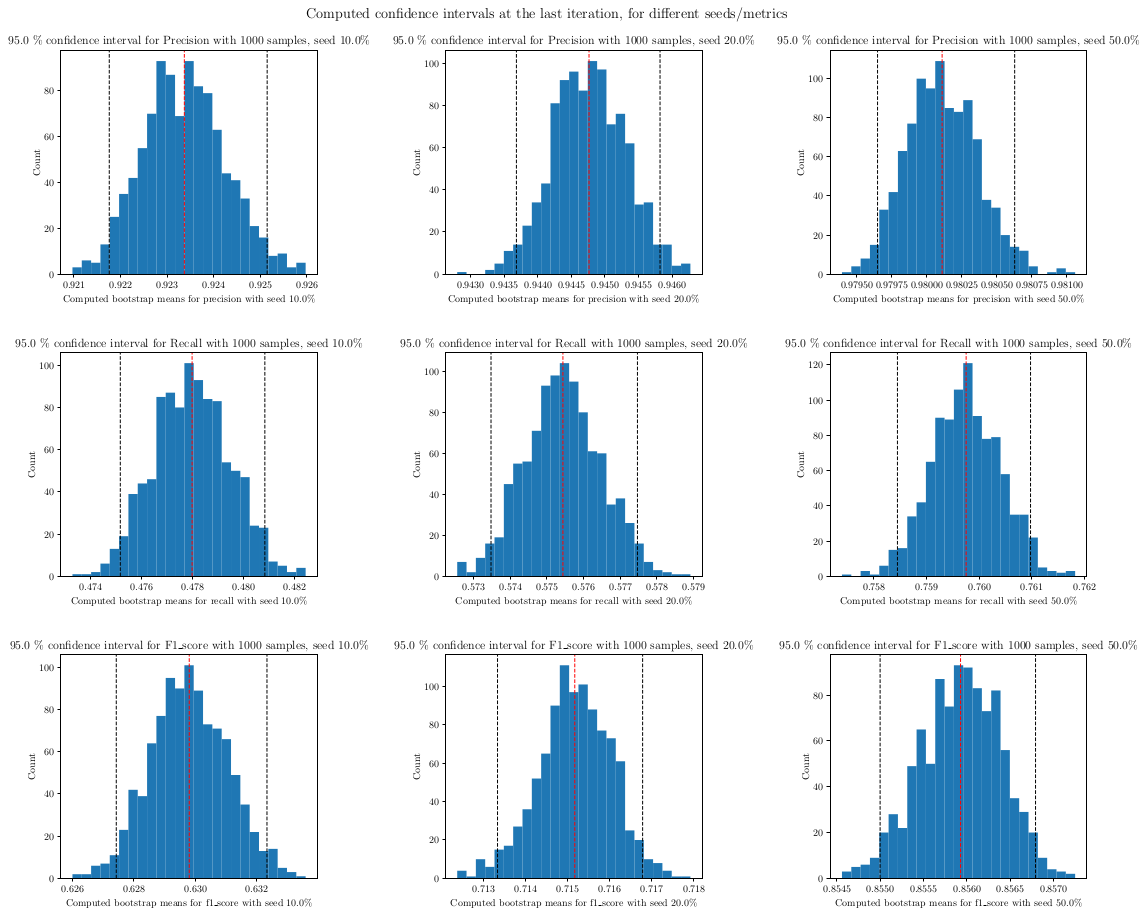

In [16]:
metrics_names = ['precision', 'recall', 'f1_score']
seeds = ['0.1', '0.2', '0.5']
index = 1
fig, axarr = plt.subplots(3, 3)
plt.subplots_adjust(left=None, bottom=None, right=2.5, top=3, wspace=0.5, hspace=0.35)

for m in metrics_names:
    for s in seeds:
        means_metric = bootstrap_metric(metrics[m][s], 1000)
        interval = confidence_interval(means_metric, 0.95)
        mean = np.mean(means_metric)
    
        plt.subplot(3, 3, index)
        plot_confidence(means_metric, mean, interval,\
                        "$95.0$ % confidence interval for {metric} with 1000 samples, seed {seed}".format(metric=m.capitalize(), seed = str(float(s)*100)+"%"),\
                        "Computed bootstrap means for {metric} with seed {seed}".format(metric=m, seed=str(float(s)*100)+"%"))
        index += 1 
fig.suptitle("Computed confidence intervals at the last iteration, for different seeds/metrics", y = 3.15, x=1.25, size=14);

## Confidence interval of timings
Plot the 95% confidence interval by bootstrapping the timing result, for each seed.

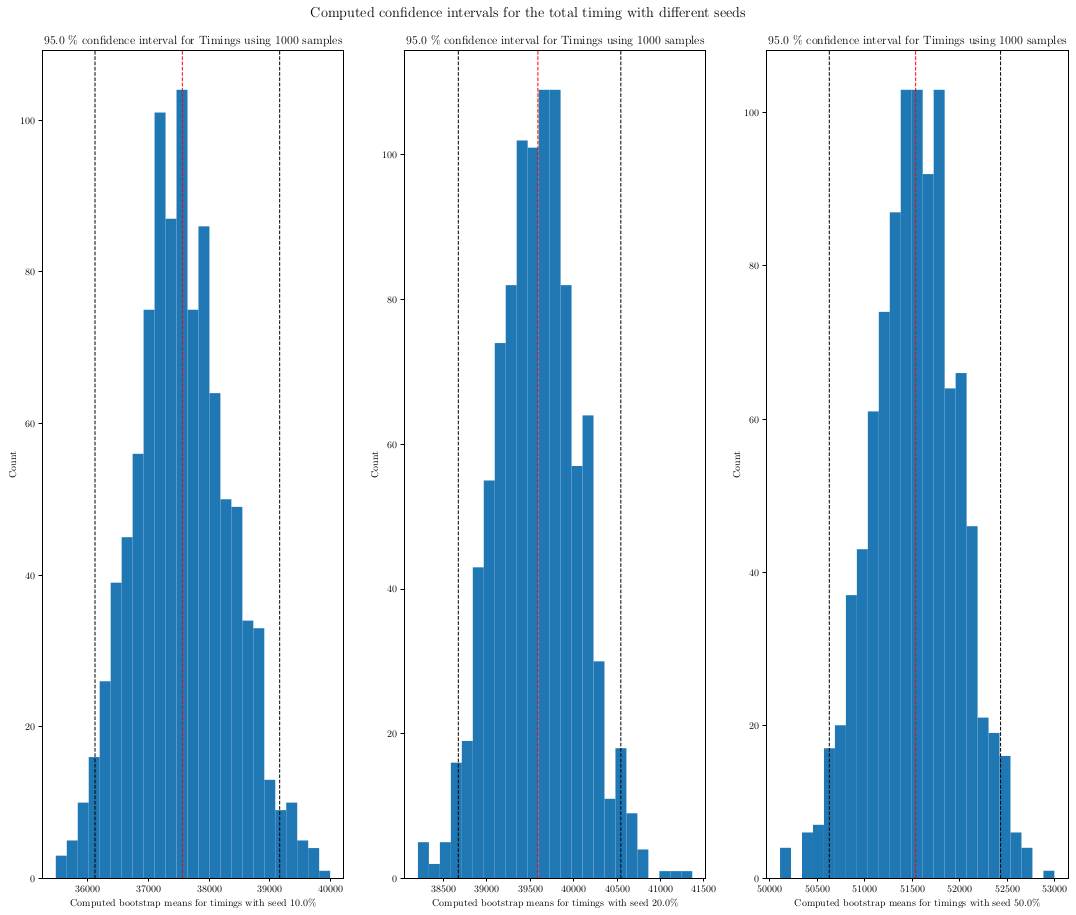

In [17]:
seeds = ['0.1', '0.2', '0.5']
index = 1
fig, axarr = plt.subplots(1, 3)
plt.subplots_adjust(left=None, bottom=None, right=2.5, top=3, wspace=0.2, hspace=0.35)

for s in seeds:
    means_timings = bootstrap_metric(timings[s], 1000)
    interval = confidence_interval(means_timings, 0.95)
    mean = np.mean(means_timings)

    plt.subplot(1, 3, index)
    plot_confidence(means_timings, mean, interval,\
                    "$95.0$ % confidence interval for Timings using 1000 samples",\
                    "Computed bootstrap means for timings with seed {seed}".format(seed=str(float(s)*100)+"%"))
    index += 1 
fig.suptitle("Computed confidence intervals for the total timing with different seeds", y = 3.15, x=1.25, size=14);

## Plot the errors for last's iterations metrics
Plot the means (and relative errors) for the metrics obtained during the last iteration, for every metric and seed.

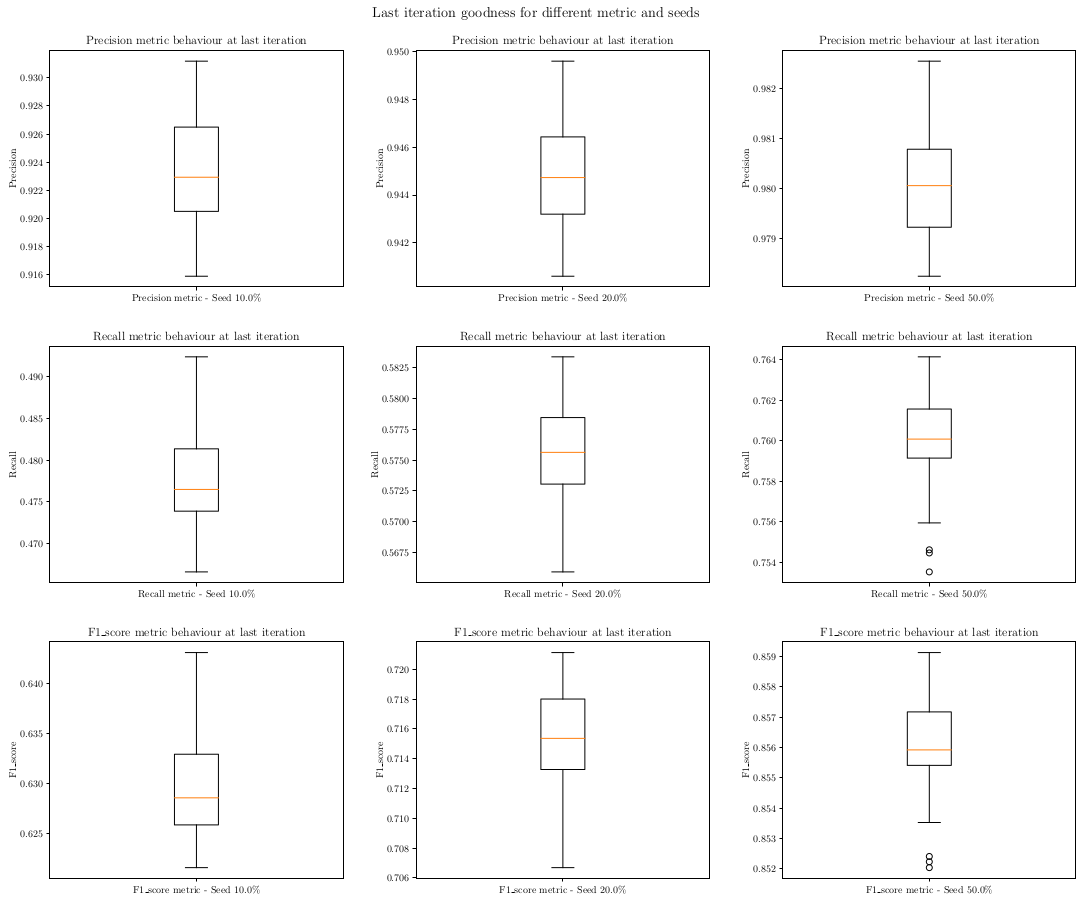

In [18]:
fig, axarr = plt.subplots(3, 3)
plt.subplots_adjust(left=None, bottom=None, right=2.5, top=3, wspace=0.25, hspace=0.25)
metrics_names = ['precision', 'recall', 'f1_score']
seeds = ['0.1', '0.2', '0.5']

iterator = 1
for m in metrics_names:
    for s in seeds:
        means = []
        last_iter = max(metrics[m][s][0].keys())
        metric_last = [val[last_iter] for val in metrics[m][s]]
        plt.subplot(3, 3, iterator)
        plt.boxplot([metric_last], labels=["{metric} metric - Seed {seed}".format(metric=m.capitalize(), seed=str(float(s)*100)+"%")])
        plt.ylabel(m.capitalize())
        plt.title("{} metric behaviour at last iteration".format(m.capitalize()))
        iterator += 1 
fig.suptitle("Last iteration goodness for different metric and seeds", y = 3.15, x=1.25, size=14);